In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

Read file from drive --- Give test_df the path to test set (as described in lab)

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Artificial_Intelligence2/imdb-reviews.csv", sep='\t')
# Only for examiner --
test_df = None
# Only for examiner --
print(df)

Preprocessing - Data Cleansing

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

def preprocess(df):
  df = df.drop('url', axis = 1)
  df['review'] = df['review'].str.lower()
  df['review'] = df['review'].str.replace("<br />", " ")
  df['review'] = df['review'].str.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)    # Remove urls
  df['review'] = df['review'].str.replace('@[A-Za-z0-9_]+','')                                              # Remove mentions
  df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))                  # Remove emojis
  df['review'] = df['review'].str.replace('[^\w\s]','')                                                     # Remove punctuation
  df['review'] = df['review'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))   # Remove stop words
  return df

df1 = preprocess(df)
print(df1)

In [275]:
most_used_words = pd.Series(' '.join(df1['review']).split()).value_counts()[:10]
print(most_used_words)

movie     79033
film      69432
one       46646
like      35623
good      26234
even      22402
would     21803
time      21669
really    21053
see       20650
dtype: int64


Preprocessing - Setting training and validation set. Includes part "only for examiner" when test_df != None

In [267]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


X = df1.drop('rating', axis=1)
X = X.squeeze()
Y = df1[['rating']]                 # only keep the rating
Y = Y.replace(['7.0', '8.0', '9.0', '10.0'], 1)
Y = Y.replace(['0.0', '1.0', '2.0', '3.0', '4.0'], 0)


X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=4)


# Only for examiner --
if test_df != None:
  test_df1 = preprocess(test_df)

  X_test = test_df1.drop('rating', axis=1)
  X_test = X_test.squeeze()
  Y_test = test_df1[['rating']]              # only keep the rating
  Y_test = Y_test.replace(['7.0', '8.0', '9.0', '10.0'], 1)
  Y_test = Y_test.replace(['0.0', '1.0', '2.0', '3.0', '4.0'], 0)
# Only for examiner --

Vectorize with Count Vectorizer

In [295]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.01)

X_train_count = vectorizer.fit_transform(X_train)

X_val_count = vectorizer.transform(X_val)

print(X_train_count.shape)
print(X_val_count.shape)

(38256, 1628)
(6752, 1628)


Vectorize with Tfidf Vectorizer

In [296]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfvectorizer = TfidfVectorizer(min_df=0.01)
X_train_tfidf = tfvectorizer.fit_transform(X_train)

X_val_tfidf = tfvectorizer.transform(X_val)

print(X_train_tfidf.shape)
print(X_val_tfidf.shape)

(38256, 1628)
(6752, 1628)


Example using what I think are the best hyperparameters with tfidf vectorizer.
Includes f1, precision and recall scores

In [297]:
# Training
classifier = LogisticRegression(C=0.1, solver='newton-cg', penalty='l2', max_iter=2000)
classifier.fit(X_train_tfidf, np.ravel(Y_train))

#Results
predictions_train = classifier.predict(X_train_tfidf)
predictions_val = classifier.predict(X_val_tfidf)

print(predictions_val)
print(np.ravel(Y_val))

#print(predictions_val.sum())
#print(np.ravel(Y_val).sum())

# F-Score

f1_train = f1_score(Y_train, predictions_train)
f1_val = f1_score(Y_val, predictions_val)

print("F1 Score (train):", f1_train)
print("F1 Score (validation):", f1_val)

#dif = abs(f1_train - f1_val)
#print(dif)

ps = precision_score(predictions_val, Y_val, average='macro')
print('Precision:', ps)
rs = recall_score(predictions_val, Y_val, average='macro')
print('Recall:', rs)

[1 1 1 ... 1 1 0]
[1 1 1 ... 1 1 0]
F1 Score (train): 0.8776529981454769
F1 Score (validation): 0.8703757646373435
Precision: 0.8681641023427286
Recall: 0.8685474808078173


Show plot using best hyperparameters with tfidf vectorizer

F1 Score Train: 0.7094594594594594
F1 Score Validation: 0.6673245830454949
F1 Score Train: 0.875643855776306
F1 Score Validation: 0.8289779326364692
F1 Score Train: 0.8699859926142874
F1 Score Validation: 0.8464790785828838
F1 Score Train: 0.8718295569834292
F1 Score Validation: 0.8557734204793027
F1 Score Train: 0.8760078725160308
F1 Score Validation: 0.8571012805587892
F1 Score Train: 0.8764340223378987
F1 Score Validation: 0.8611955420466059
F1 Score Train: 0.8776814046964249
F1 Score Validation: 0.8637883413286813
F1 Score Train: 0.8773646921335184
F1 Score Validation: 0.8673469387755103
F1 Score Train: 0.8780519023391251
F1 Score Validation: 0.8669677983389188
F1 Score Train: 0.8778404237143345
F1 Score Validation: 0.8693496646252553


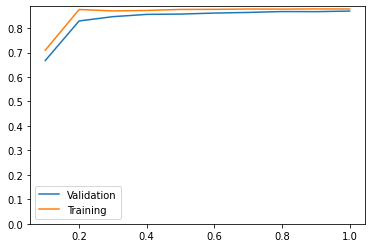

In [301]:
import matplotlib.pyplot as plt

list_f1=[]
list_f1_train=[]
list_precision=[]
list_recall=[]
list_sample_size=[]

for times in range(10):
  # training
  X, X_unused, y, y_unused = train_test_split(X_train_tfidf, Y_train, test_size=1 - (times * 0.1 + 0.005), random_state=0)

  classifier = LogisticRegression(C=0.1, solver='newton-cg', penalty='l2', max_iter=2000)
  classifier.fit(X, np.ravel(y))

  results_train = classifier.predict(X)

  # validation
  results = classifier.predict(X_val_tfidf)

  # score
  f1_train = f1_score(y, results_train)
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(Y_val, results)
  print("F1 Score Validation: " + str(f1))

  precision = precision_score(Y_val, results)
  recall = recall_score(Y_val, results)
  list_precision.append(precision)
  list_recall.append(recall)

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

# print(plot_data)
plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

Show plot using best hyperparameters with count vectorizer

F1 Score Train: 0.9357798165137614
F1 Score Validation: 0.7300582425930616
F1 Score Train: 0.9023850504057045
F1 Score Validation: 0.8349289237017697
F1 Score Train: 0.8947435733469753
F1 Score Validation: 0.8505914999269754
F1 Score Train: 0.8920643021178871
F1 Score Validation: 0.8583916083916083
F1 Score Train: 0.8936579115951313
F1 Score Validation: 0.8643274853801168
F1 Score Train: 0.8939378502292409
F1 Score Validation: 0.8675679604593691
F1 Score Train: 0.8925120258822528
F1 Score Validation: 0.8698570177998249
F1 Score Train: 0.8918700975001833
F1 Score Validation: 0.8712697483908718
F1 Score Train: 0.8912156736791391
F1 Score Validation: 0.8730668222935513
F1 Score Train: 0.8902418110101183
F1 Score Validation: 0.8743791995325738


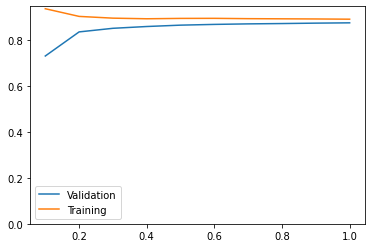

In [306]:
import matplotlib.pyplot as plt

list_f1=[]
list_f1_train=[]
list_precision=[]
list_recall=[]
list_sample_size=[]

for times in range(10):
  # training
  X, X_unused, y, y_unused = train_test_split(X_train_count, Y_train, test_size=1 - (times * 0.1 + 0.005), random_state=0)

  classifier = LogisticRegression(C= 0.01, solver='lbfgs', penalty='l2', max_iter=2000)
  classifier.fit(X, np.ravel(y))

  results_train = classifier.predict(X)

  # validation
  results = classifier.predict(X_val_count)

  # score
  f1_train = f1_score(y, results_train)
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(Y_val, results)
  print("F1 Score Validation: " + str(f1))

  precision = precision_score(Y_val, results)
  recall = recall_score(Y_val, results)
  list_precision.append(precision)
  list_recall.append(recall)

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

# print(plot_data)
plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])